In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import os
import os.path as osp
import imageio
from tqdm import tqdm
from transforms3d.euler import mat2euler, euler2mat
import pyrender
import trimesh
import cv2

EPS = 1e-8

from utils import viz_camera_poses

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Load data
from dataloader import load_middlebury_data
DATA = load_middlebury_data("data/templeRing")
# reference: https://vision.middlebury.edu/mview/


Loading data/templeRing


47it [00:00, 116.42it/s]


In [7]:
ref_view = DATA[2]
neighbor_views = [DATA[i] for i in [0, 1, 3, 4]]


In [8]:
for view in neighbor_views:
    assert view['rgb'].shape == ref_view['rgb'].shape  
height, width = ref_view['rgb'].shape[:2]


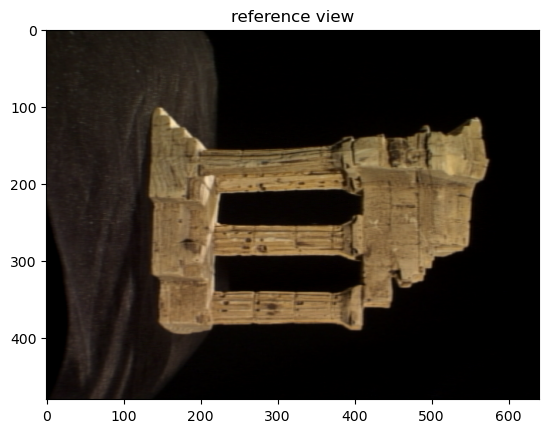

In [9]:
plt.title("reference view")
plt.imshow(ref_view["rgb"])
plt.show()

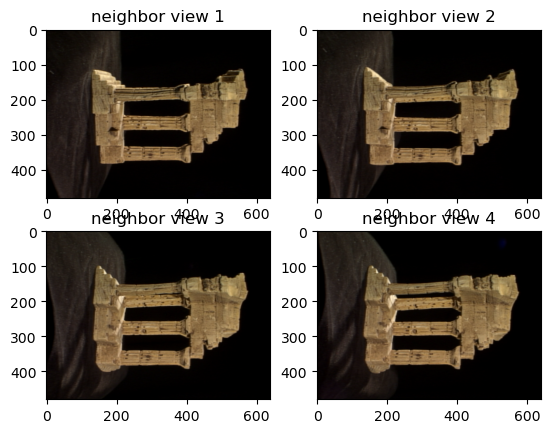

In [10]:
for i, view in enumerate(neighbor_views):
    plt.subplot(2, 2, i+1)
    plt.title("neighbor view " + str(i+1)) 
    plt.imshow(view["rgb"])
plt.show()

In [11]:
## vector of depths to sweep our plane across 
def get_depths(min_depth, max_depth, num_depths):
    depths = np.linspace(min_depth, max_depth, num_depths)
    return np.float32(depths)

In [12]:
min_depth = 0.52 
max_depth = 0.62 
num_depths = 25

depths = get_depths(min_depth, max_depth, num_depths)
depths

array([0.52      , 0.52416664, 0.5283333 , 0.5325    , 0.5366667 ,
       0.54083335, 0.545     , 0.5491667 , 0.55333334, 0.5575    ,
       0.56166667, 0.56583333, 0.57      , 0.57416666, 0.5783333 ,
       0.5825    , 0.58666664, 0.5908333 , 0.595     , 0.5991667 ,
       0.60333335, 0.6075    , 0.6116667 , 0.61583334, 0.62      ],
      dtype=float32)

The planes will be swept fronto-parallel to the reference camera, so no
reprojection needs to be done for this image.  Simply compute the normalized
patches across the entire image.

In [13]:
from two_view_stereo import image2patch

ref_view_patches = image2patch(ref_view['rgb'].astype(np.float)/255.0, k_size=5) # [h,w,k*k,3]
ref_view_patches.shape


INFO - 2023-01-07 09:41:57,522 - utils - Note: NumExpr detected 10 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - 2023-01-07 09:41:57,522 - utils - NumExpr defaulting to 8 threads.
/var/folders/br/b02pf78j6dx6fwdcgbdv2dnh0000gn/T/ipykernel_10138/1713906341.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ref_view_patches = image2patch(ref_view['rgb'].astype(np.float)/255.0, k_size=5) # [h,w,k*k,3]


5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)


(480, 640, 25, 3)

We'll sweep a series of planes that are fronto-parallel to the right camera.
The image from the left camera is to be projected onto each of these planes,
normalized, and then compared to the normalized right image.


In [14]:
from plane_sweep_stereo import backproject_corners, project_points, warp_neighbor_to_ref, zncc_kernel_2D
volume = []

## for each depth, compute and sum the disparity maps between ref and each neighboring view
for depth in tqdm(depths):
    zncc = np.zeros((height, width))
    for neighbor_view in neighbor_views:

        K_ref = ref_view['K']
        K_neighbor = neighbor_view['K']
        
        R_ref = ref_view['R']
        t_ref = np.expand_dims(ref_view['T'], axis=1)
        Rt_ref = np.hstack((R_ref, t_ref))
        
        R_neighbor = neighbor_view['R']
        t_neighbor = np.expand_dims(neighbor_view['T'], axis=1)
        Rt_neighbor = np.hstack((R_neighbor, t_neighbor))

        warped_neighbor = warp_neighbor_to_ref(backproject_corners, project_points, depth, neighbor_view['rgb'], K_ref, Rt_ref, K_neighbor, Rt_neighbor)
       
        # patchify this warped left image.

        neighbor_view_patches = image2patch(warped_neighbor.astype(np.float)/255.0, k_size=5)

        # Compute the ZNCC score between the reference and neighbor images.
        ## summing zncc scores across all neighboring views
        zncc += zncc_kernel_2D(ref_view_patches, neighbor_view_patches)
        
    #     break
    # break

    volume.append(zncc)


  0%|          | 0/25 [00:00<?, ?it/s]/var/folders/br/b02pf78j6dx6fwdcgbdv2dnh0000gn/T/ipykernel_10138/2921342167.py:24: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  neighbor_view_patches = image2patch(warped_neighbor.astype(np.float)/255.0, k_size=5)


(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)


  4%|▍         | 1/25 [00:38<15:14, 38.12s/it]

(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)


  8%|▊         | 2/25 [01:15<14:32, 37.93s/it]

(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)


 12%|█▏        | 3/25 [01:53<13:52, 37.82s/it]

(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)


 16%|█▌        | 4/25 [02:30<13:10, 37.63s/it]

(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)


 20%|██        | 5/25 [03:08<12:30, 37.52s/it]

(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)


 24%|██▍       | 6/25 [03:45<11:51, 37.47s/it]

(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)


 28%|██▊       | 7/25 [04:22<11:13, 37.43s/it]

(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)


 32%|███▏      | 8/25 [05:00<10:35, 37.40s/it]

(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)


 36%|███▌      | 9/25 [05:37<09:58, 37.39s/it]

(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)


 40%|████      | 10/25 [06:15<09:20, 37.38s/it]

(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)


 44%|████▍     | 11/25 [06:52<08:43, 37.37s/it]

(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)


 48%|████▊     | 12/25 [07:29<08:05, 37.38s/it]

(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)


 52%|█████▏    | 13/25 [08:07<07:28, 37.39s/it]

(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)


 56%|█████▌    | 14/25 [08:44<06:51, 37.39s/it]

(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)


 60%|██████    | 15/25 [09:21<06:13, 37.39s/it]

(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)


 64%|██████▍   | 16/25 [09:59<05:36, 37.39s/it]

(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)


 68%|██████▊   | 17/25 [10:36<04:59, 37.40s/it]

(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)


 72%|███████▏  | 18/25 [11:14<04:21, 37.39s/it]

(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)


 76%|███████▌  | 19/25 [11:51<03:44, 37.38s/it]

(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)


 80%|████████  | 20/25 [12:28<03:06, 37.37s/it]

(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)


 84%|████████▍ | 21/25 [13:06<02:29, 37.36s/it]

(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)


 88%|████████▊ | 22/25 [13:43<01:52, 37.34s/it]

(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)


 92%|█████████▏| 23/25 [14:20<01:14, 37.38s/it]

(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)


 96%|█████████▌| 24/25 [14:58<00:37, 37.39s/it]

(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)
(3, 3)
(3, 1)
5
img (480, 640, 3)
(480, 640, 25)
(480, 640, 25, 3)


100%|██████████| 25/25 [15:35<00:00, 37.43s/it]


In [15]:

# All of these separate ZNCC layers get stacked together into a volume.
volume_np = np.dstack(volume)

# We're going to use the simplest algorithm to select a depth layer per pixel --
# the argmax across depth labels.
vol_argmax = volume_np.argmax(axis=2)

# Remap the label IDs back to their associated depth values.
depth_map = depths[vol_argmax]



# Visualize the cost volume:

In [16]:
from IPython.display import Image
from copy import deepcopy
volume_np_viz = deepcopy(volume_np)
volume_np_viz =  volume_np_viz -  volume_np_viz.min()
volume_np_viz = volume_np_viz  / volume_np_viz.max()
frames = [(volume_np_viz[:,:,i]*255).astype(np.uint8) for i in range(volume_np_viz.shape[-1])]
imageio.mimsave("./volume_np.gif",frames, fps=10)

<img src="volume_np.gif" width="750" align="center">

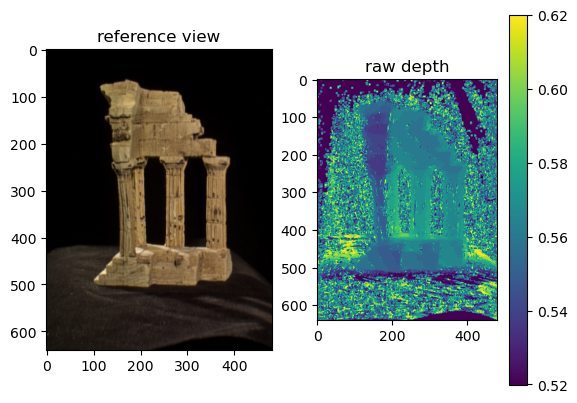

In [17]:
plt.subplot(1,2,1)
plt.title("reference view")
plt.imshow(cv2.rotate(ref_view["rgb"], cv2.ROTATE_90_COUNTERCLOCKWISE))

plt.subplot(1,2,2)
plt.title("raw depth")
plt.imshow(cv2.rotate(depth_map, cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.colorbar()
plt.show()

### Postprocessing and visualization

(3, 3)
(90698, 3)
(3, 1)


/var/folders/br/b02pf78j6dx6fwdcgbdv2dnh0000gn/T/ipykernel_10138/2579144256.py:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = (mask > 0).astype(np.float)


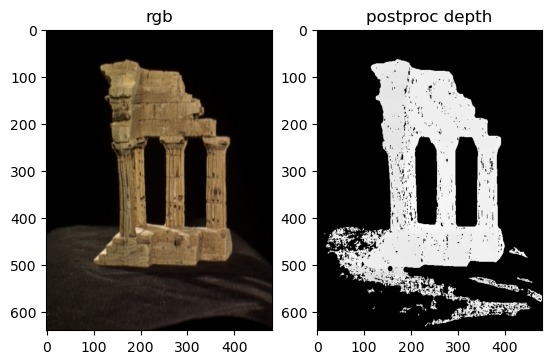

In [18]:
from plane_sweep_stereo import backproject
from two_view_stereo import postprocess
xyz_cam = backproject(depth_map, K_ref)

mask, pcl_world, pcl_cam, pcl_color = postprocess(
    depth_map,
    ref_view["rgb"],
    xyz_cam,
    R_wc=ref_view["R"],
    T_wc=ref_view["T"][:,None],
    z_near=0.5,
    z_far=0.6,
)

mask = (mask > 0).astype(np.float)

plt.subplot(1, 2, 1)
plt.title("rgb")
plt.imshow(cv2.rotate(ref_view["rgb"], cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.subplot(1, 2, 2)
plt.title("postproc depth")
plt.imshow(cv2.rotate(depth_map * mask, cv2.ROTATE_90_COUNTERCLOCKWISE), cmap="gray")
plt.show()


In [19]:
import k3d
import numpy as np

def viz_3d_embedded(pcl, color):
    plot = k3d.plot(camera_auto_fit=True)
    color = color.astype(np.uint8)
    color32 = (color[:, 0] * 256**2 + color[:, 1] * 256**1 + color[:, 2] * 256**0).astype(
        np.uint32
    )
    plot += k3d.points(pcl.astype(float), color32, point_size=0.001, shader="flat")
    plot.display()

In [20]:
viz_3d_embedded(pcl_world, pcl_color.astype(np.uint8))


/Users/renu/opt/anaconda3/envs/cis580_22_fall/lib/python3.8/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  warnings.warn(
/Users/renu/opt/anaconda3/envs/cis580_22_fall/lib/python3.8/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "uint32" does not match required type "uint32". A coerced copy has been created.
  warnings.warn(


Output()

In [ ]:
## 1. Two View Stereo


In [21]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import cv2

EPS = 1e-8

from utils import viz_camera_poses


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading data/templeRing


47it [00:00, 133.66it/s]


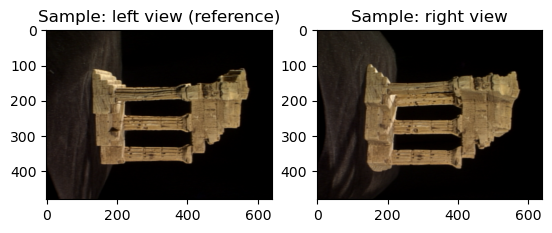

In [22]:
# Load data
from dataloader import load_middlebury_data
DATA = load_middlebury_data("data/templeRing")
# reference: https://vision.middlebury.edu/mview/

view_i, view_j = DATA[0], DATA[3]
# viz_camera_poses([view_i, view_j])

plt.subplot(1, 2, 1)
plt.title("Sample: left view (reference)")
plt.imshow(view_i["rgb"])
plt.subplot(1, 2, 2)
plt.title("Sample: right view")
plt.imshow(view_j["rgb"])
plt.show()

In [24]:
from two_view_stereo import (
    rectify_2view,
    compute_rectification_R,
    compute_right2left_transformation,
)

R_wi, T_wi = view_i["R"], view_i["T"][:, None]  # p_i = R_wi @ p_w + T_wi
R_wj, T_wj = view_j["R"], view_j["T"][:, None]  # p_j = R_wj @ p_w + T_wj

R_ji, T_ji, B = compute_right2left_transformation(R_wi, T_wi, R_wj, T_wj)
assert T_ji[1, 0] > 0, "here we assume view i should be on the left, not on the right"

R_irect = compute_rectification_R(T_ji)

rgb_i_rect, rgb_j_rect, K_i_corr, K_j_corr = rectify_2view(
    view_i["rgb"],
    view_j["rgb"],
    R_irect,
    R_irect @ R_ji,
    view_i["K"],
    view_j["K"],
    u_padding=20,
    v_padding=20,
)


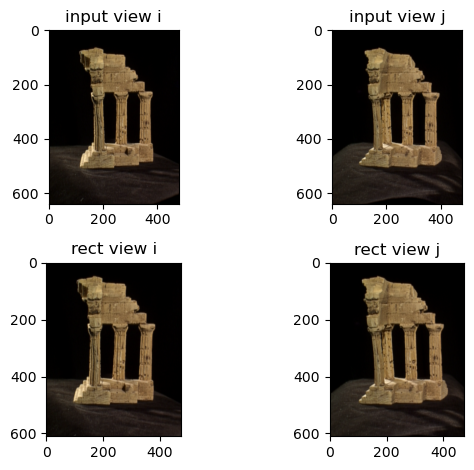

In [25]:
plt.subplot(2, 2, 1)
plt.title("input view i")
plt.imshow(cv2.rotate(view_i["rgb"], cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.subplot(2, 2, 2)
plt.title("input view j")
plt.imshow(cv2.rotate(view_j["rgb"], cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.subplot(2, 2, 3)
plt.title("rect view i")
plt.imshow(cv2.rotate(rgb_i_rect, cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.subplot(2, 2, 4)
plt.title("rect view j")
plt.imshow(cv2.rotate(rgb_j_rect, cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.tight_layout()
plt.show()

In [26]:
from two_view_stereo import image2patch, ssd_kernel

assert K_i_corr[1, 1] == K_j_corr[1, 1], "This hw assumes the same focal Y length"
assert (K_i_corr[0] == K_j_corr[0]).all(), "This hw assumes the same K on X dim"
assert (
    rgb_i_rect.shape == rgb_j_rect.shape
), "This hw makes rectified two views to have the same shape"

h, w = rgb_i_rect.shape[:2]

d0 = K_j_corr[1, 2] - K_i_corr[1, 2]

patches_i = image2patch(rgb_i_rect.astype(float) / 255.0, 3)  # [h,w,k*k,3]
patches_j = image2patch(rgb_j_rect.astype(float) / 255.0, 3)  # [h,w,k*k,3]

vi_idx, vj_idx = np.arange(h), np.arange(h)
disp_candidates = vi_idx[:, None] - vj_idx[None, :] + d0
valid_disp_mask = disp_candidates > 0.0

# as an example
u = 400

buf_i, buf_j = patches_i[:, u], patches_j[:, u]
value = ssd_kernel(buf_i, buf_j)  # each row is one pix from left, col is the disparity
# Students, why we compute this `_upper` ?
_upper = value.max() + 1.0
value[~valid_disp_mask] = _upper


3
img (475, 611, 3)
(475, 611, 9)
(475, 611, 9, 3)
3
img (475, 611, 3)
(475, 611, 9)
(475, 611, 9, 3)


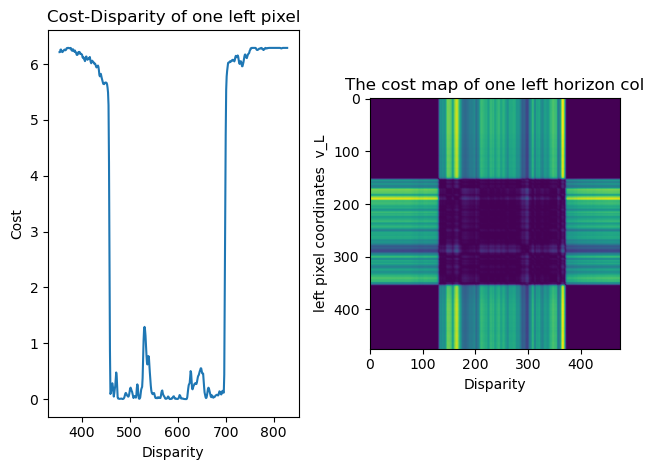

In [27]:
plt.subplot(1,2,1)
# Viz the  disparity-cost of u=500, v=200 on left view
v = 200
plt.title("Cost-Disparity of one left pixel")
plt.xlabel("Disparity")
plt.ylabel("Cost")
plt.plot(disp_candidates[v], value[v])
plt.subplot(1,2,2)
plt.title("The cost map of one left horizon col")
plt.xlabel("Disparity")
plt.ylabel("left pixel coordinates  v_L")
plt.imshow(value)
plt.tight_layout()
plt.show()

In [28]:
# example for the pixel (u=500,v=300) from the left view
v = 300
best_matched_right_pixel = value[v].argmin()
best_matched_left_pixel = value[:,best_matched_right_pixel].argmin()
print(v, best_matched_left_pixel)
consistent_flag = best_matched_left_pixel == v
print(consistent_flag)

# example for the pixel (u=500,v=380) from the left view
v = 380
best_matched_right_pixel = value[v].argmin()
best_matched_left_pixel = value[:,best_matched_right_pixel].argmin()
print(v, best_matched_left_pixel)
consistent_flag = best_matched_left_pixel == v
print(consistent_flag)

300 300
True
380 113
False


In [29]:
from two_view_stereo import compute_disparity_map

disp_map, consistency_mask = compute_disparity_map(
    rgb_i_rect, rgb_j_rect, d0=K_j_corr[1, 2] - K_i_corr[1, 2], k_size=5
)


5
img (475, 611, 3)
(475, 611, 25)
(475, 611, 25, 3)
5
img (475, 611, 3)
(475, 611, 25)
(475, 611, 25, 3)


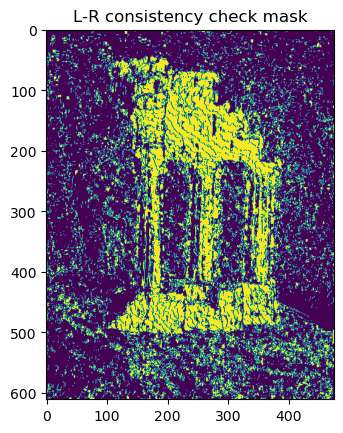

In [30]:
plt.imshow(cv2.rotate(consistency_mask, cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.title("L-R consistency check mask")
plt.show()

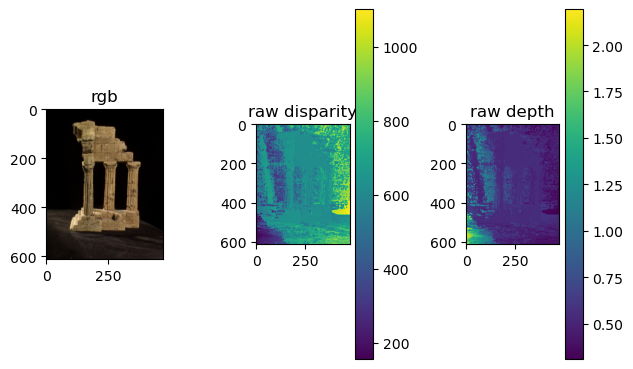

In [31]:
from two_view_stereo import compute_dep_and_pcl

# * 3. compute depth map and filter them
dep_map, xyz_cam = compute_dep_and_pcl(disp_map, B, K_i_corr)

plt.subplot(1, 3, 1)
plt.title("rgb")
plt.imshow(cv2.rotate(rgb_i_rect, cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.subplot(1, 3, 2)
plt.title("raw disparity")
plt.imshow(cv2.rotate(disp_map, cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.colorbar()
plt.subplot(1, 3, 3)
plt.title("raw depth")
plt.imshow(cv2.rotate(dep_map, cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.colorbar()
plt.tight_layout()
plt.show()


(3, 3)
(45595, 3)
(3, 1)


/var/folders/br/b02pf78j6dx6fwdcgbdv2dnh0000gn/T/ipykernel_10138/2786132076.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = (mask > 0).astype(np.float)


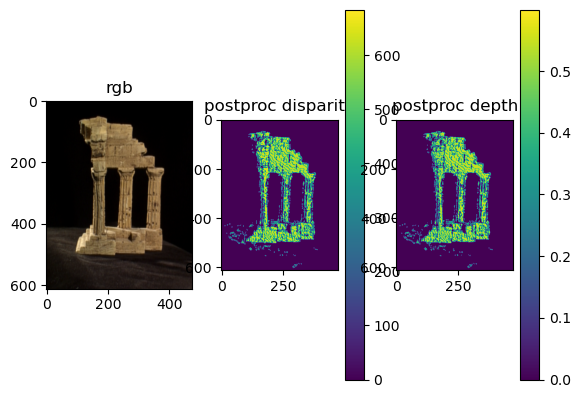

In [32]:
from two_view_stereo import postprocess

mask, pcl_world, pcl_cam, pcl_color = postprocess(
    dep_map,
    rgb_i_rect,
    xyz_cam,
    R_wc=R_irect @ R_wi,
    T_wc=R_irect @ T_wi,
    consistency_mask=consistency_mask,
    z_near=0.5,
    z_far=0.6,
)

mask = (mask > 0).astype(np.float)

plt.subplot(1, 3, 1)
plt.title("rgb")
plt.imshow(cv2.rotate(rgb_i_rect, cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.subplot(1, 3, 2)
plt.title("postproc disparity")
plt.imshow(cv2.rotate(disp_map * mask, cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.colorbar()
plt.subplot(1, 3, 3)
plt.title("postproc depth")
plt.imshow(cv2.rotate(dep_map * mask, cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.colorbar()
plt.show()


In [33]:
!pip install jupyter_contrib_nbextensions
!jupyter contrib nbextension install --user

[I 10:38:06 InstallContribNbextensionsApp] jupyter contrib nbextension install --user
[I 10:38:06 InstallContribNbextensionsApp] Installing jupyter_contrib_nbextensions nbextension files to jupyter data directory
[I 10:38:06 InstallContribNbextensionsApp] Installing /Users/renu/opt/anaconda3/envs/cis580_22_fall/lib/python3.8/site-packages/jupyter_contrib_nbextensions/nbextensions/rubberband -> rubberband
[I 10:38:06 InstallContribNbextensionsApp] Up to date: /Users/renu/Library/Jupyter/nbextensions/rubberband/icon.png
[I 10:38:06 InstallContribNbextensionsApp] Up to date: /Users/renu/Library/Jupyter/nbextensions/rubberband/main.css
[I 10:38:06 InstallContribNbextensionsApp] Up to date: /Users/renu/Library/Jupyter/nbextensions/rubberband/readme.md
[I 10:38:06 InstallContribNbextensionsApp] Up to date: /Users/renu/Library/Jupyter/nbextensions/rubberband/main.js
[I 10:38:06 InstallContribNbextensionsApp] Up to date: /Users/renu/Library/Jupyter/nbextensions/rubberband/rubberband.yaml
[I 10

In [34]:
!jupyter nbextension enable varInspector/main
!jupyter nbextension install --py --user k3d
!jupyter labextension install @jupyter-widgets/jupyterlab-manager
!jupyter labextension install k3d

Enabling notebook extension varInspector/main...
      - Validating: OK
Installing /Users/renu/opt/anaconda3/envs/cis580_22_fall/lib/python3.8/site-packages/k3d/static -> k3d
Making directory: /Users/renu/Library/Jupyter/nbextensions/k3d/
Copying: /Users/renu/opt/anaconda3/envs/cis580_22_fall/lib/python3.8/site-packages/k3d/static/fflate.js -> /Users/renu/Library/Jupyter/nbextensions/k3d/fflate.js
Copying: /Users/renu/opt/anaconda3/envs/cis580_22_fall/lib/python3.8/site-packages/k3d/static/headless.html -> /Users/renu/Library/Jupyter/nbextensions/k3d/headless.html
Copying: /Users/renu/opt/anaconda3/envs/cis580_22_fall/lib/python3.8/site-packages/k3d/static/standalone.js -> /Users/renu/Library/Jupyter/nbextensions/k3d/standalone.js
Copying: /Users/renu/opt/anaconda3/envs/cis580_22_fall/lib/python3.8/site-packages/k3d/static/standalone.js.map -> /Users/renu/Library/Jupyter/nbextensions/k3d/standalone.js.map
Copying: /Users/renu/opt/anaconda3/envs/cis580_22_fall/lib/python3.8/site-package

In [35]:
!pip3 install k3d

In [37]:
import k3d
import numpy as np

def viz_3d_embedded(pcl, color):
    plot = k3d.plot(camera_auto_fit=True)
    color = color.astype(np.uint8)
    color32 = (color[:, 0] * 256**2 + color[:, 1] * 256**1 + color[:, 2] * 256**0).astype(
        np.uint32
    )
    plot += k3d.points(pcl.astype(float), color32, point_size=0.001, shader="flat")
    plot.display()

In [ ]:
#### SSD Two view reconstruction results

In [39]:
viz_3d_embedded(pcl_world, pcl_color.astype(np.uint8))

Output()

In [ ]:
#### SAD Two view reconstruction results

In [40]:
from two_view_stereo import two_view ,sad_kernel

pcl_sad, pcl_color_sad, disp_map_sad, dep_map_sad = two_view(DATA[0], DATA[2], 5, sad_kernel)
viz_3d_embedded(pcl_sad, pcl_color_sad.astype(np.uint8))

5
img (457, 606, 3)
(457, 606, 25)
(457, 606, 25, 3)
5
img (457, 606, 3)
(457, 606, 25)
(457, 606, 25, 3)
(3, 3)
(51159, 3)
(3, 1)


Output()

In [ ]:
#### ZNCC Two view reconstruction results

In [41]:
from two_view_stereo import two_view, zncc_kernel

pcl_zncc, pcl_color_zncc, disp_map_zncc, dep_map_zncc = two_view(DATA[0], DATA[2], 5, zncc_kernel)


5
img (457, 606, 3)
(457, 606, 25)
(457, 606, 25, 3)
5
img (457, 606, 3)
(457, 606, 25)
(457, 606, 25, 3)
(3, 3)
(43161, 3)
(3, 1)


In [42]:
viz_3d_embedded(pcl_zncc, pcl_color_zncc.astype(np.uint8))

Output()

In [ ]:
### 1.5 Aggregation

In [44]:
from two_view_stereo import two_view, ssd_kernel, sad_kernel, zncc_kernel

pcl_list, pcl_color_list, disp_map_list, dep_map_list = [], [], [], []
pairs = [(0, 2), (2, 4), (5, 7), (8, 10), (13, 15), (16, 18), (19, 21), (22, 24), (25, 27)]
# for i in range(13, 28, 3):
for pair in pairs:
    i,j = pair
    _pcl, _pcl_color, _disp_map, _dep_map = two_view(DATA[i], DATA[j], 5, sad_kernel)
    pcl_list.append(_pcl)
    pcl_color_list.append(_pcl_color)
    disp_map_list.append(_disp_map)
    dep_map_list.append(_dep_map)

5
img (457, 606, 3)
(457, 606, 25)
(457, 606, 25, 3)
5
img (457, 606, 3)
(457, 606, 25)
(457, 606, 25, 3)
(3, 3)
(51159, 3)
(3, 1)
5
img (457, 606, 3)
(457, 606, 25)
(457, 606, 25, 3)
5
img (457, 606, 3)
(457, 606, 25)
(457, 606, 25, 3)
(3, 3)
(53715, 3)
(3, 1)
5
img (457, 606, 3)
(457, 606, 25)
(457, 606, 25, 3)
5
img (457, 606, 3)
(457, 606, 25)
(457, 606, 25, 3)
(3, 3)
(39851, 3)
(3, 1)
5
img (457, 606, 3)
(457, 606, 25)
(457, 606, 25, 3)
5
img (457, 606, 3)
(457, 606, 25)
(457, 606, 25, 3)
(3, 3)
(28228, 3)
(3, 1)
5
img (457, 606, 3)
(457, 606, 25)
(457, 606, 25, 3)
5
img (457, 606, 3)
(457, 606, 25)
(457, 606, 25, 3)
(3, 3)
(34572, 3)
(3, 1)
5
img (457, 606, 3)
(457, 606, 25)
(457, 606, 25, 3)
5
img (457, 606, 3)
(457, 606, 25)
(457, 606, 25, 3)
(3, 3)
(35392, 3)
(3, 1)
5
img (457, 606, 3)
(457, 606, 25)
(457, 606, 25, 3)
5
img (457, 606, 3)
(457, 606, 25)
(457, 606, 25, 3)
(3, 3)
(46067, 3)
(3, 1)
5
img (457, 606, 3)
(457, 606, 25)
(457, 606, 25, 3)
5
img (457, 606, 3)
(457, 606,

KeyboardInterrupt: 

In [45]:
plot = k3d.plot(camera_auto_fit=True)
for pcl, color in zip(pcl_list, pcl_color_list):
    color = color.astype(np.uint8)
    color32 = (color[:, 0] * 256**2 + color[:, 1] * 256**1 + color[:, 2] * 256**0).astype(
        np.uint32
    )
    plot += k3d.points(pcl.astype(float), color32, point_size=0.001, shader="flat")
plot.display()

Output()